In [1]:
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
from scipy import signal
import scipy.cluster.hierarchy as spc
from pandas import read_excel
from ipywidgets import widgets
from ipywidgets import interactive, HBox, VBox
import plotly.io as pio

# Google Trend

### Creation of pickles with data from google trend

In [ ]:
pytrends = TrendReq(hl='en-US', tz=360)

#list topics 
ecology_topic = ["/m/02mgp"] 
green_peace = ["green peace"] 
sea_shepherd = ["sea sheperd"] 
climate_change_topic = ["/m/0cs9q"]
giec = ["giec"]
global_warming_topic = ["/m/0d063v"]

kw_list = [ecology_topic,green_peace,sea_shepherd,climate_change_topic,giec,global_warming_topic]

#list country https://abbreviations.yourdictionary.com/articles/abbreviations-european-union.html
country_list = ["FR","BE","BG","CY","CZ","DE","DK","EE","ES","FI","AT","GB","GR","HR","HU","IE","IT","LT","LU","LV","MT","NL","PL","PT","RO","SE","SI","SK"]
country_list_iso = ["FRA","BEL","BGR","CYP","CZE","DEU","DNK","EST","ESP","FIN","AUT","GBR","GRC","HRV","HUN","IRL","ITA","LTU","LUX","LVA","MLT","NLD","POL","PRT","ROU","SWE","SVN","SVK"]


for x in range(0, len(kw_list)):
    
    #adding just the first one
    pytrends.build_payload(kw_list[x], cat=0, timeframe='all', geo=country_list[0], gprop='')
    pytrends.interest_over_time()
    newDataframe = pytrends.interest_over_time()[kw_list[x]]
    listColumn = []
    listColumn.append(country_list[0])
        
    for y in range(1, len(country_list)): 
        pytrends.build_payload(kw_list[x], cat=0, timeframe='all', geo=country_list[y], gprop='')
        ledata = pytrends.interest_over_time()
        if not ledata.empty:
            ledata.drop(ledata.columns[len(ledata.columns)-1], axis=1, inplace=True)
            newDataframe = pd.concat([newDataframe, ledata], axis=1, join='inner')
            listColumn.append(country_list[y])

    newDataframe.columns = listColumn
    newDataframe = newDataframe[19:] #remove first strange Data
    newDataframe.to_pickle("./data_martin/GoogleTrend"+str(x)+".pkl") 



### Events releate to climate change

In [2]:
data = [["2006-05-24", "An Inconvenient Truth Movie"],
        ['2006-11-06', "COP12"], 
        ['2007-12-03', "COP13"], 
        ['2007-09-18', "IPCC 4th Assessment Report"],
        ['2008-12-01', "COP14"], 
        ['2009-12-07', "COP15"],
        ["2009-12-18", "Copenhagen Accord"],
        ['2009-12-07', "COP15"],
        ['2010-11-28', "COP16"],
        ['2011-11-27', "COP17"],
        ['2012-11-26', "COP18"],
        ['2013-11-11', "COP19"],
        ['2014-12-01', "COP20"],
        ['2015-11-30', "COP21"],
        ["2015-12-12", "Paris Agreement"],
        ['2016-11-07', "COP22"],
        ['2017-11-06', "COP23"],
        ["2018-09-08", "Rise for climate"],
        ['2018-12-03', "COP24"],
        ['2019-06-17', "COP25"],
        ["2019-03-19", "Start of School strike for the climate"]] 
  
# Create the pandas DataFrame 
climateChangeEvent = pd.DataFrame(data, columns = ['Date', 'Name']) 

Read Pickles 

In [3]:
df_ecology = pd.read_pickle("./data_martin/GoogleTrend0.pkl")
df_green_peace = pd.read_pickle("./data_martin/GoogleTrend1.pkl")
df_sea_shepherd = pd.read_pickle("./data_martin/GoogleTrend2.pkl")
df_climate_change = pd.read_pickle("./data_martin/GoogleTrend3.pkl")
df_giec = pd.read_pickle("./data_martin/GoogleTrend4.pkl")
df_global_warming = pd.read_pickle("./data_martin/GoogleTrend5.pkl")

### Plot Google trend

In [4]:
def plot_lines(df,value_smooth):
    fig = go.Figure()
    for x in df.columns:
        if value_smooth == 0:
            fig.add_trace(go.Scatter(x=df.index, y=df[x], mode='lines',name=x))
        else:
            fig.add_trace(go.Scatter(x=df.index, y=signal.savgol_filter(df[x],value_smooth, 3), mode='lines',name=x))
    fig.show()

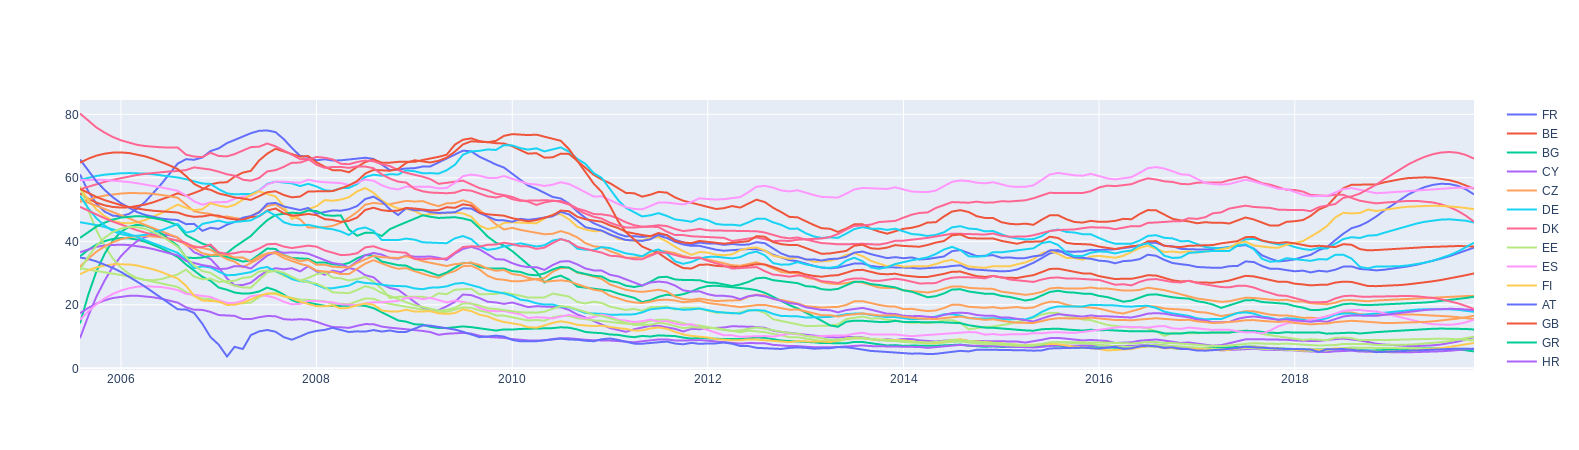

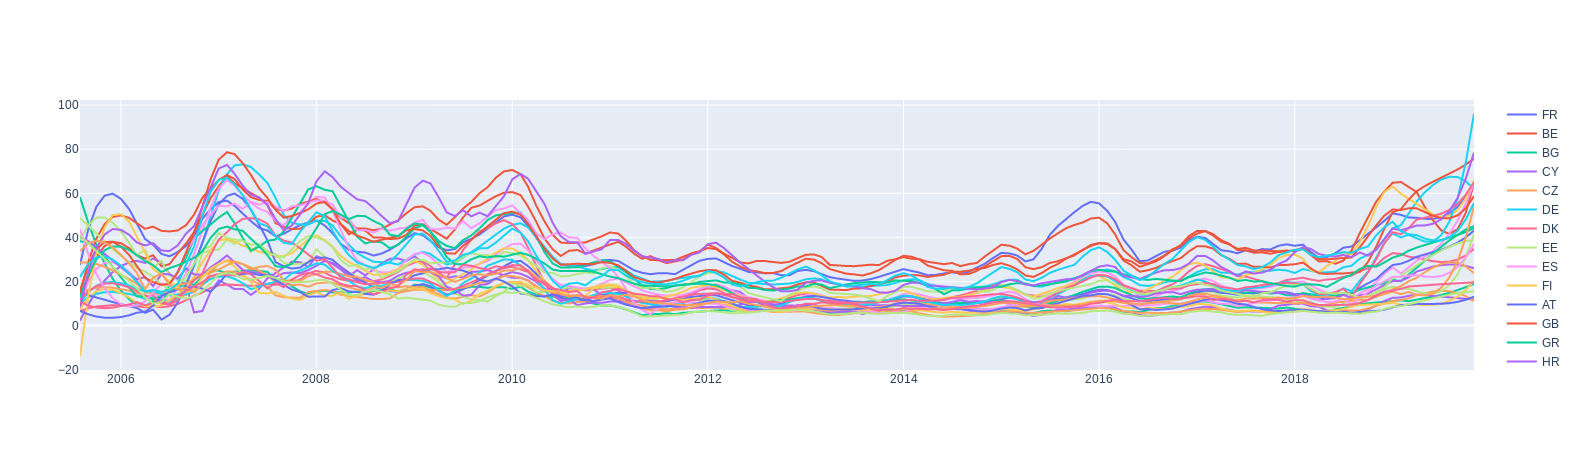

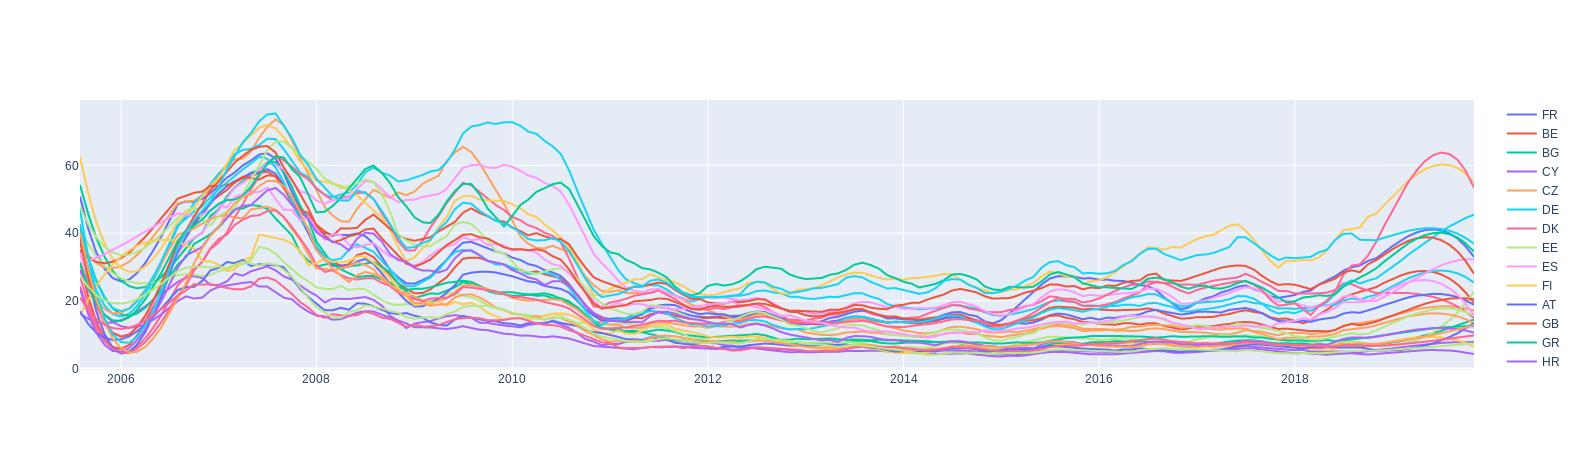

In [5]:
plot_lines(df_ecology,25)
plot_lines(df_climate_change,15)
plot_lines(df_global_warming,25)
#plot_lines(df_green_peace,15)
#plot_lines(df_sea_shepherd,25)
#plot_lines(df_giec,15)

### Regroup country with similarity interest on subjects

In [47]:
#Creation matric correlation

df_corr_ecology = df_ecology.corr(method ='pearson') 
df_corr_climate_change = df_climate_change.corr(method ='pearson') 
df_corr_global_warming = df_global_warming.corr(method ='pearson') 
#df_corr_green_peace = df_green_peace.corr(method ='pearson') 
#df_corr_sea_shepherd = df_sea_shepherd.corr(method ='pearson') 
#df_corr_giec = df_giec.corr(method ='pearson') 

#define a matrix of correlation for the 3 topics (climate change, ecology and global warming)
corr =  df_corr_climate_change.values + df_corr_global_warming.values + df_corr_ecology.values

In [48]:

#fig = go.Figure(data=go.Heatmap(z=corr))
#fig.update_layout(
#    autosize=False,
#    width=500,
#    height=500,
#)
#fig.show()

#cluster countries based on correlation measure
def getIdx(corr,variableTweak):
    pdist = spc.distance.pdist(corr)
    linkage = spc.linkage(pdist, method='complete')
    idx = spc.fcluster(linkage, variableTweak * pdist.max(), 'distance')
    return idx

def getGroupe(number,idx):
    groupe = []
    for i in range(0,len(idx)):
        x = idx[i]
        if x == number:
            groupe.append(i)
    return groupe

def maxGroupe(idx):
    return max(idx)

def plotDifferentGroup(idx,dfPlot,indicePlot):
    for i in range(1,maxGroupe(idx)+1):
        df1 = dfPlot[dfPlot.columns[getGroupe(i,idx)]]
        plot_lines(df1,indicePlot)

idx = getIdx(corr,0.83)



### Plot to show difference between the two differents groups

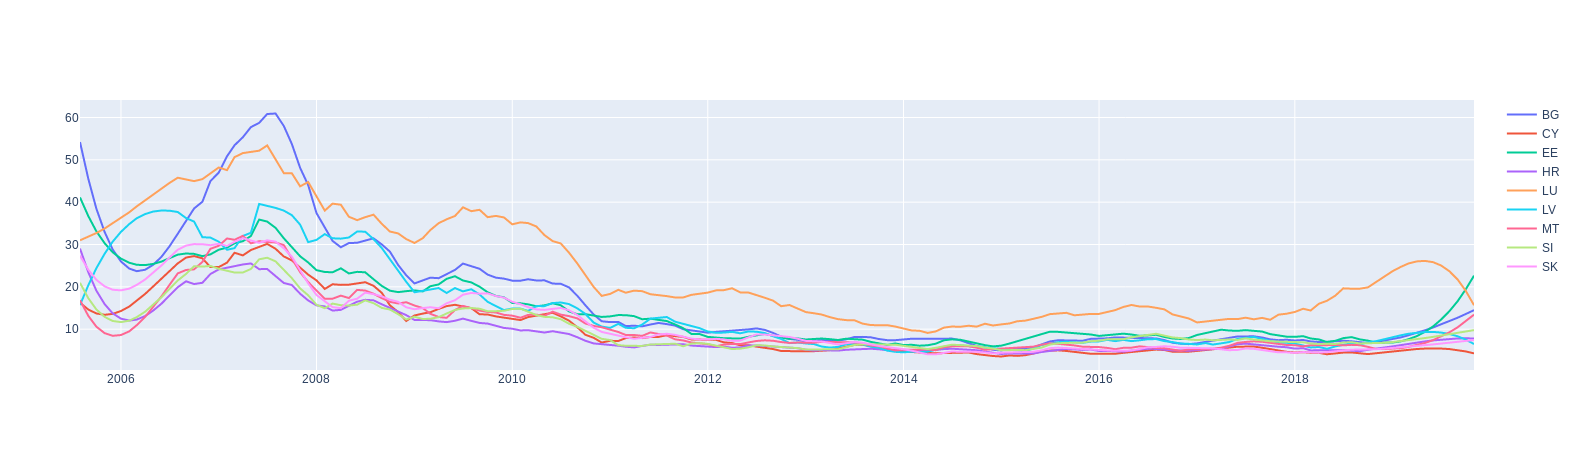

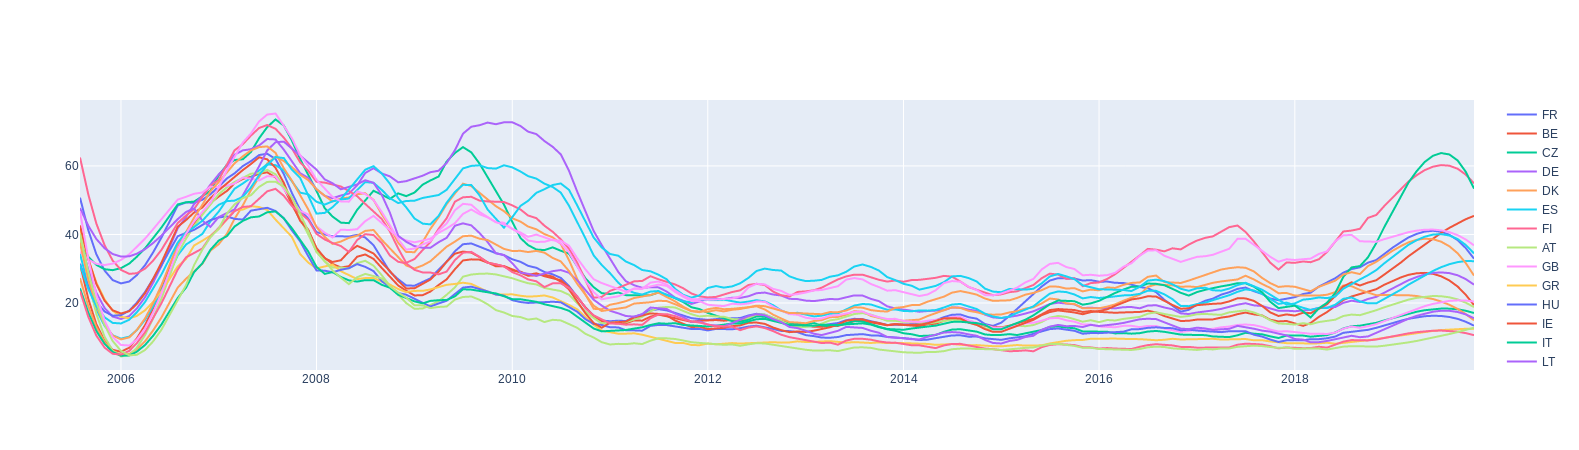

In [49]:
plotDifferentGroup(idx,df_global_warming,25)

### Map location of the two differents group

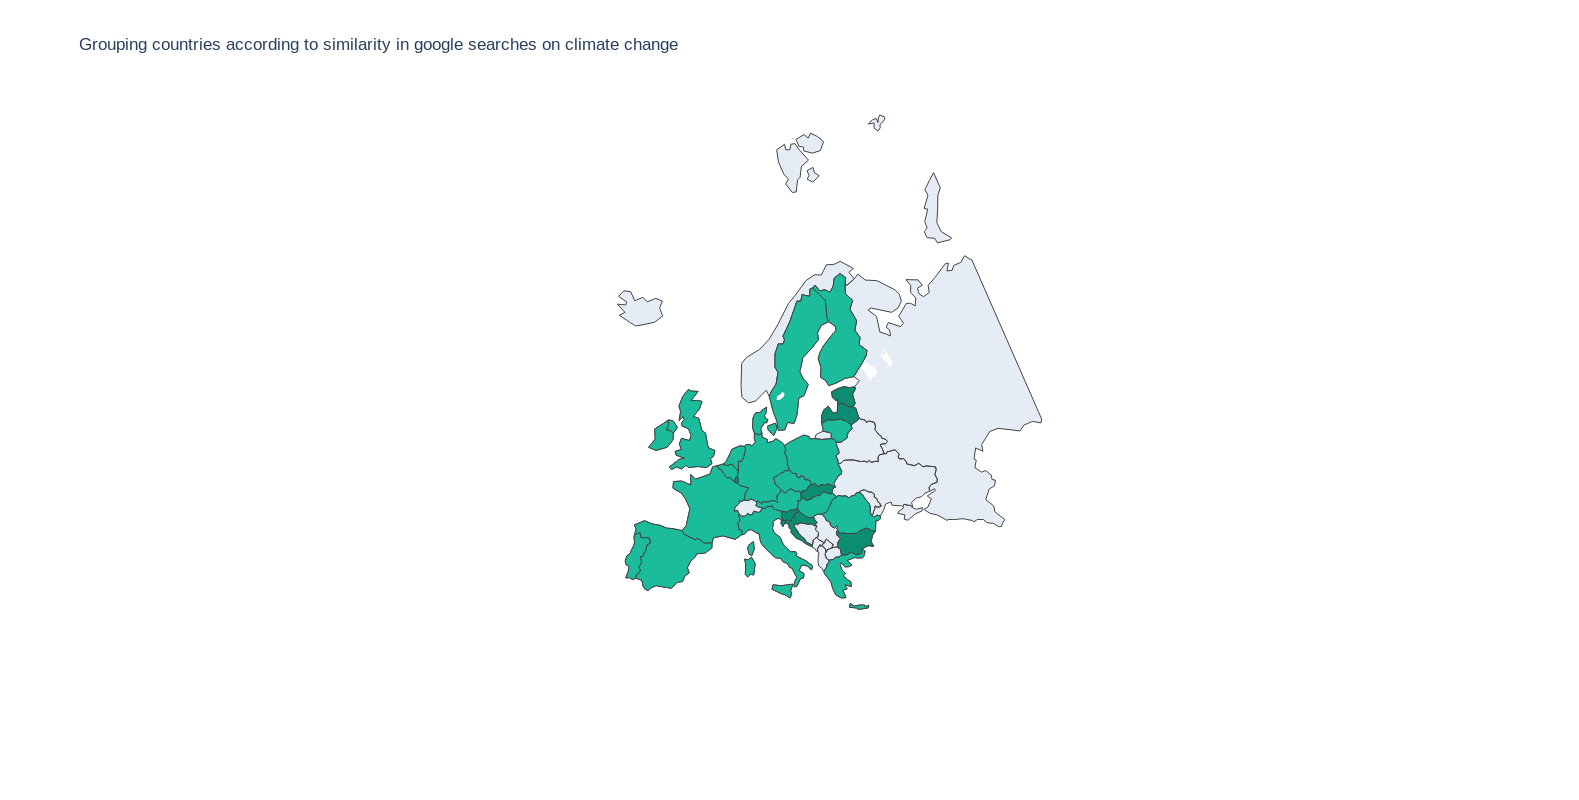

In [15]:
def plotMapStatic(idx):
    fig = go.Figure(data=go.Choropleth(
        locations=country_list_iso, # Spatial coordinates
        z = idx, # Data to be color-coded
        locationmode = 'ISO-3', # set of locations match entries in `locations`
        colorscale=[
            # Let first 10% (0.1) of the values have color rgb(0, 0, 0)
            [0, "rgb(12,140,113)"],
            [0.5, "rgb(12,140,113)"],
            [0.5, "rgb(26,188,156)"],
            [1, "rgb(26,188,156)"]],

        colorbar_title = "Millions USD",
        showscale = False,
    ))

    fig.update_layout(
        title_text = 'Grouping countries according to similarity in google searches on climate change',
        geo_scope='europe', # limite map scope to USA
        autosize=False,
        width=800,
        height=800,
    )
    fig.show()

plotMapStatic(idx)

# Eurobarometer

In [16]:
my_sheet = 'Sheet1'
file_name = "./data_martin/europa_survey/AT.xlsx"
df = read_excel(file_name, sheet_name = my_sheet)
eurobarometer = df[["Date"]]

for country in country_list:
    file_name = "./data_martin/europa_survey/"+country+".xlsx"
    df = read_excel(file_name, sheet_name = my_sheet)
    eurobarometer = pd.concat([eurobarometer, df[["Climate change"]]], axis=1, join='inner')

eurobarometer.columns = ["Date"]+country_list
eurobarometer.index = eurobarometer["Date"]
eurobarometer = eurobarometer.drop(['Date'], axis=1)


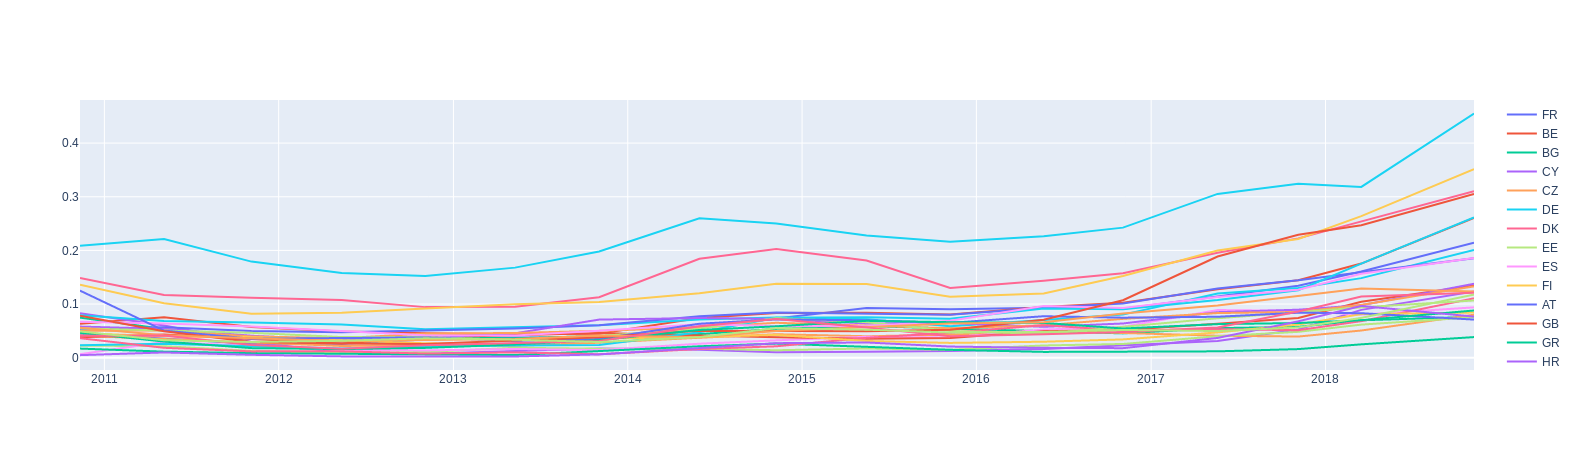

In [17]:
plot_lines(eurobarometer[country_list],5)

### Map showing evolution eurobarometer

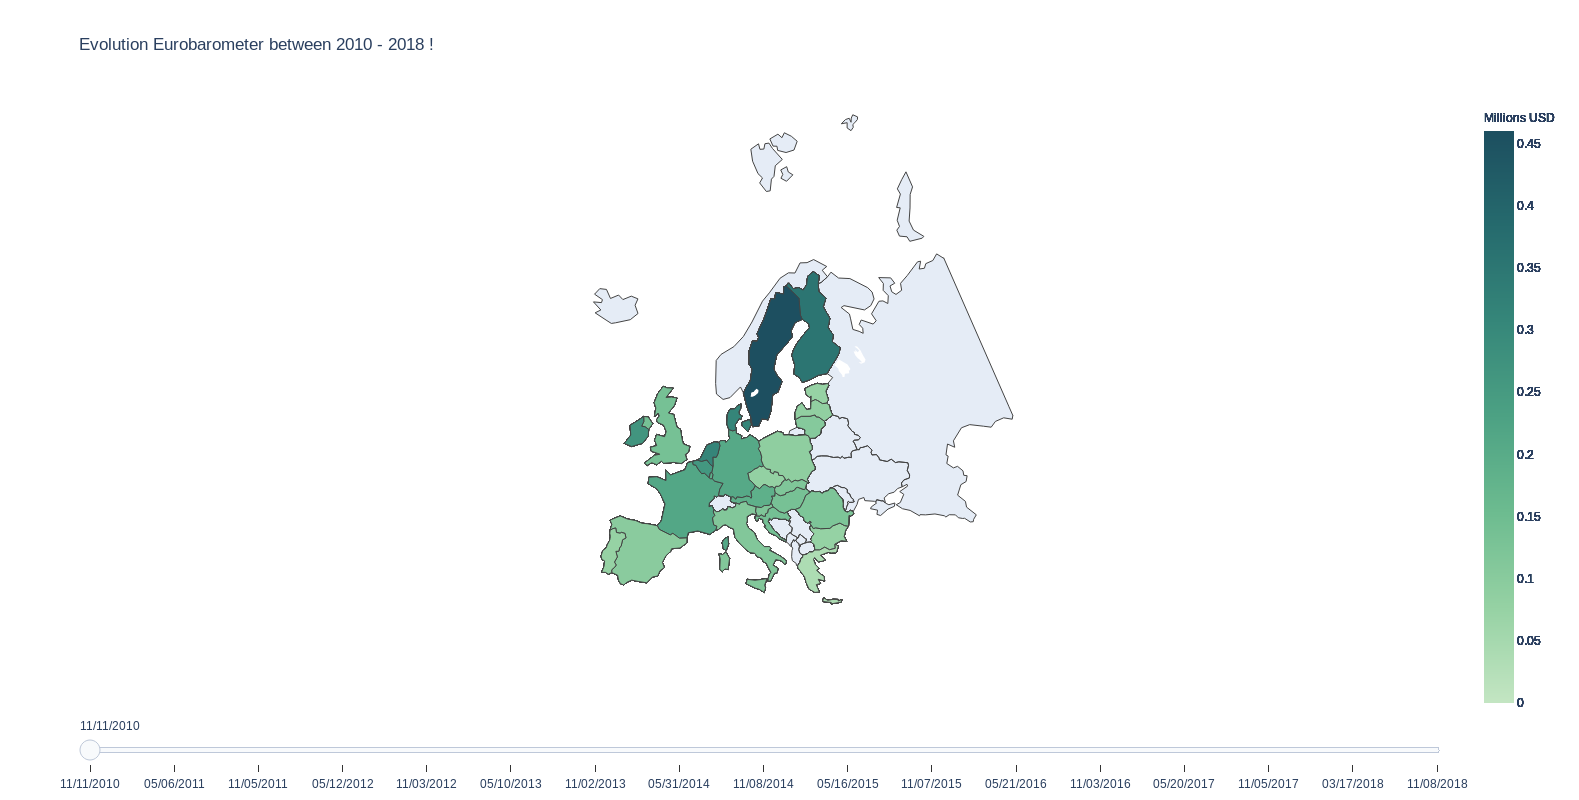

In [18]:

### create empty list for data object:    
data_slider = []

for ix in range(0,17):
    # I select the year (and remove DC for now)
    #df_sected_crime = eurobarometer[country_list]

    #for col in df_sected_crime.columns:  # I transform the columns into string type so I can:
    #    df_sected_crime[col] = df_sected_crime[col].astype(str)


    ### create the dictionary with the data for the current year
    data_one_year = dict(
                        type='choropleth',
                        locations=country_list_iso, # Spatial coordinates
                        z = eurobarometer[country_list].iloc[ix], # Data to be color-coded
                        locationmode = 'ISO-3', # set of locations match entries in `locations`
                        autocolorscale=False,
                        colorscale = "Blugrn",
                        zmax = 0.46,
                        zmin = 0,
                        colorbar_title = "Millions USD",
                        )
    ix = ix+1
    data_slider.append(data_one_year)  # I add the dictionary to the list of dictionaries for the slider


steps = []

for i in range(len(data_slider)):
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label=eurobarometer.index[i].strftime("%m/%d/%Y")) # label to be displayed for each step (year)
    step['args'][1][i] = True
    steps.append(step)

##  I create the 'sliders' object from the 'steps' 
sliders = [dict(active=0, pad={"t": 1}, steps=steps)] 

layout = dict(geo=dict(scope='europe',),sliders=sliders,title_text = 'Evolution Eurobarometer between 2010 - 2018',autosize=False, width=800,height=800,)

# I create the figure object:

fig = dict(data=data_slider, layout=layout,) 



pio.show(fig)

### Global evolution Eurobarometer  

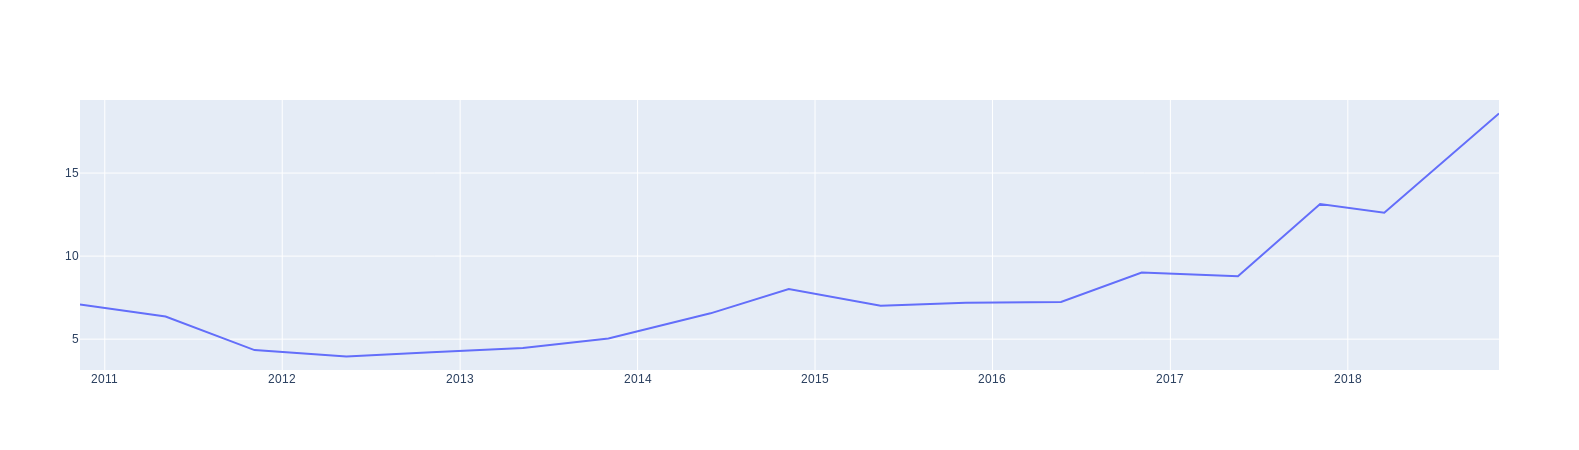

In [82]:

eurobarometer_norm = eurobarometer.copy()
for x in range(0,17):
        eurobarometer_norm.iloc[:,x] = eurobarometer_norm.iloc[:,x]/eurobarometer_norm.iloc[:,x].max()
        
eurobarometer_norm.loc[:,'Total_normalize'] = eurobarometer_norm.sum(axis=1)
    
fig = go.Figure()  
fig.add_trace(go.Scatter(x=eurobarometer_norm.index, y=eurobarometer_norm["Total_normalize"], mode='lines',name=x))
#fig.add_trace(go.Scatter(x=eurobarometer_norm.index, y=signal.savgol_filter(eurobarometer_norm["Total_normalize"],3, 2), mode='lines',name=x))
fig.show()

# Analyse coverage of climate change in european media

In [59]:
my_sheet = 'Sheet2'
file_name = "./data_martin/coverage_media.xlsx"
coverageMedia = read_excel(file_name, sheet_name = my_sheet)
coverageMedia = coverageMedia.T
def plot_lines2(df,value_smooth):
    fig = go.Figure()
    for x in range(0,22):
        if value_smooth == 0:
            fig.add_trace(go.Scatter(x=df.index, y=coverageMedia.iloc[2:,x], mode='lines',name=x))
        else:
            fig.add_trace(go.Scatter(x=df.index, y=signal.savgol_filter(coverageMedia.iloc[2:,x],value_smooth, 3), mode='lines',name=x))
    fig.show()


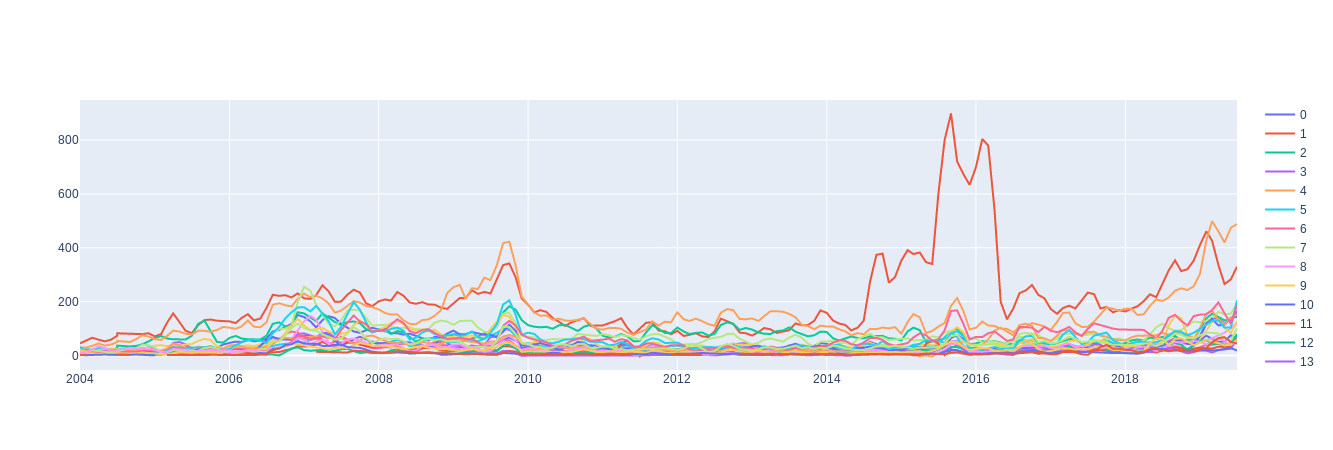

In [60]:
plot_lines2(coverageMedia,5)

Plot normalize

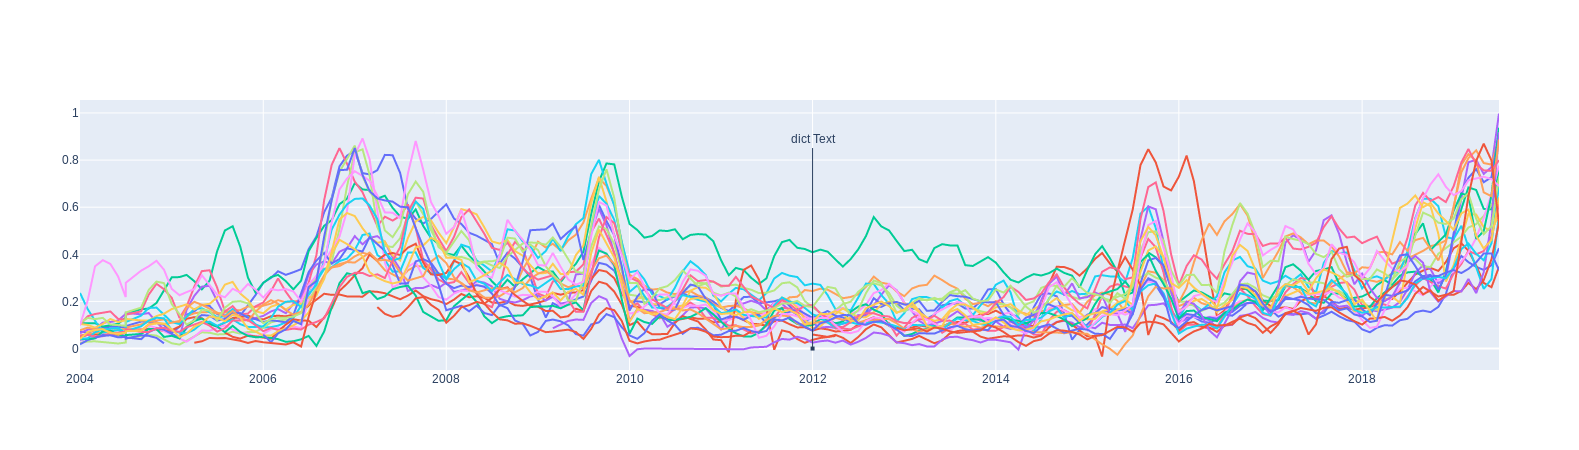

In [83]:
   
def plot_lines3(df,value_smooth,interval1,interval2):
    fig = go.Figure()
    for x in range(interval1,interval2):
        dataSerie = coverageMedia.iloc[2:,x]/coverageMedia.iloc[2:,x].max()
        if value_smooth == 0:
            fig.add_trace(go.Scatter(x=df.index, y=dataSerie, mode='lines',name=x))
        else:
            fig.add_trace(go.Scatter(x=df.index, y=signal.savgol_filter(dataSerie,value_smooth, 3), mode='lines',name=x))
    fig.update_layout(
    showlegend=False,
    annotations=[
        go.layout.Annotation(
            x="2012-01-01",
            y=0,
            xref="x",
            yref="y",
            text="dict Text",
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-210
        )
    ]
    )
    fig.show()
    
plot_lines3(coverageMedia,7,0,22)

### total publication in europe with all data normalize to not favorise big media

In [57]:
coverageMedia_norm = coverageMedia.copy()
for x in range(0,22):
        coverageMedia_norm.iloc[2:,x] = coverageMedia_norm.iloc[2:,x]/coverageMedia_norm.iloc[2:,x].max()
        
coverageMedia_norm.loc[:,'Total_normalize'] = coverageMedia_norm.sum(axis=1)

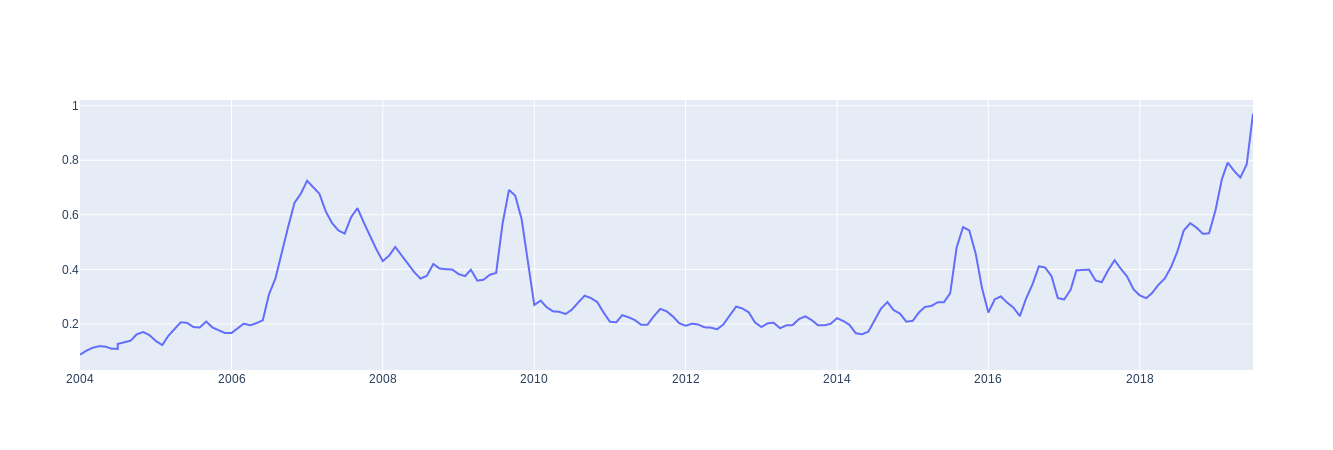

In [58]:
plot_lines3(coverageMedia,7,22,23)